# TPSNOV22 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️

<br>

## Details of competition
#### URL: https://www.kaggle.com/competitions/tabular-playground-series-nov-2022/overview

<br>

#### Topic
Provide a fun and approachable-for-anyone tabular dataset to model.

<br>

#### Background

<br>

##### About the Tabular Playground Series
Kaggle competitions are incredibly fun and rewarding, but they can also be intimidating for people who are relatively new in their data science journey. In the past, we've launched many Playground competitions that are more approachable than our Featured competitions and thus, more beginner-friendly.

<br>

**The goal of these competitions is to provide a fun and approachable-for-anyone tabular dataset to model.** These competitions are a great choice for people looking for something in between the Titanic Getting Started competition and the Featured competitions. If you're an established competitions master or grandmaster, these probably won't be much of a challenge for you; thus, we encourage you to avoid saturating the leaderboard.

<br>

For each monthly competition, we'll be offering Kaggle Merchandise for the top three teams. And finally, because we want these competitions to be more about learning, we're limiting team sizes to 3 individuals.

<br>

## Reference: TPSNOV22 EDA which makes sense

### Main URL: 
- https://www.kaggle.com/code/ambrosm/tpsnov22-eda-which-makes-sense

<br>

### EDA which makes sense ⭐️⭐️⭐️⭐️⭐️
This notebook shows an exploratory data analysis for the November 2022 Tabular Playground competition.

In [34]:
# import module
import glob, pickle, scipy.optimize, scipy.special
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import log_loss

## Reading the data
- The members of our ensemble are given as 5000 submission files. Every submission file contains 40000 predictions. We read all of this data into an array X.


- We save X as a pickle file. If you load it from this notebook's output, you can save some time:

In [35]:
with open('./X.pickle', 'rb') as f: X = pickle.load(f)

In [54]:
%%time
X = np.zeros((40000, 5000))
names = sorted(glob.glob('./tabular-playground-series-nov-2022/submission_files/*.csv'))
for i, name in enumerate(names):
#     assert len(name) == 77
    sub = pd.read_csv(name)
    assert (sub.id == np.arange(40000)).all()
    if i == 0: 
        print('Sample input file:')
        display(sub)
    X[:,i] = sub.pred.values
    if i % 1000 == 0: print(i)
with open('X.pickle', 'wb') as f: pickle.dump(X, f)
    
X_dev = X[:20000]
X_test = X[20000:]

Sample input file:


,id,pred
0,0,0.709336
1,1,0.452988
2,2,0.675462
3,3,0.481046
4,4,0.957339
...,...,...
39995,39995,0.382515
39996,39996,0.352498
39997,39997,0.577554
39998,39998,0.712353


0
1000
2000
3000
4000
CPU times: user 19.8 s, sys: 1.69 s, total: 21.5 s
Wall time: 24.3 s


<br>

#### The first half of the data (i.e. 20000 of the 40000 rows) are labeled. We read these labels into an array y.

<br>

In [43]:
y = pd.read_csv('./tabular-playground-series-nov-2022/train_labels.csv')
assert (y.id == np.arange(20000)).all()
display(y)
y = y.label.values

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0
...,...,...
19995,19995,1
19996,19996,1
19997,19997,0
19998,19998,0


##### The classification problem is balanced: There are 50 % positive and 50 % negative samples:

In [44]:
y.mean()

0.5

<br>

## Outliers and null values

<br>

##### Let's do a sanity check:

- The predictions should be probabilities between 0 and 1, but X contains some values outside this range.


- The labels are all 0 or 1, as is to be expected.


- There are no null values.

<br>

**Insight:** We should clean the data before we start ensembling. We can drop columns which contain outliers, drop training rows which contain outliers, or we can simply clip the data to the interval [0, 1].

In [45]:
print('Minimum and maximum X values:', X.min(), X.max())
print('Unique labels:               ', np.unique(y))
print('Null values in X and y:      ', np.isnan(X).sum(), np.isnan(y).sum())

Minimum and maximum X values: -0.376186 1.356611
Unique labels:                [0 1]
Null values in X and y:       0 0


#### We count the outliers:

In [46]:
print(f"Values below zero:           {(X < 0).sum()}")
print(f"Values above one:           {(X > 1).sum()}")
print(f"Rows containing outliers:    {((X < 0) | (X > 1)).any(axis=1).sum()} of {X.shape[0]}")
print(f"Columns containing outliers:  {((X < 0) | (X > 1)).any(axis=0).sum()} of {X.shape[1]}")

Values below zero:           1967
Values above one:           15592
Rows containing outliers:    3606 of 40000
Columns containing outliers:  108 of 5000


## Duplicates

<br>

#### We check for duplicate rows or columns in the data. There are no duplicates.

In [47]:
print(np.unique(X, axis=0).shape)
print(np.unique(X, axis=1).shape)

(40000, 5000)
(40000, 5000)


## File names and log loss

#### According to the data description, the 5000 file names correspond to the log loss of the file. We verify this claim:

In [52]:
print('name                          log loss')
for sub in range(5):
    name_loss = float(names[sub][61:-4])
    print(names[sub][61:], name_loss, log_loss(y, X_dev[:,sub]))
    
log_loss_list = []
for sub in range(X.shape[1]):
    name_loss = float(names[sub][61:-4])
    log_loss_list.append(name_loss)
    assert abs(name_loss - log_loss(y, X_dev[:,sub])) < 1e-10

name                          log loss
63195.csv 63195.0 0.6222863195129075
07245.csv 7245.0 0.6223807245068153
26578.csv 26578.0 0.622542657774157
22291.csv 22291.0 0.6247722290993437
55681.csv 55681.0 0.6253455680841075


AssertionError: 

- The histogram of the 5000 scores shows that all models have loglosses between 0.622 and 0.758. Did you notice that these scores are rather weak? A dummy model which predicts 0.5 all the time has a log loss of 0.693 (red line in the diagram). A perfect model would have a log loss of 0.

<br>

- Insight: Half the input models are worse than a dummy classifier! Should we drop these columns immediately? No. Although these columns have high logloss, they still contain information which can be valuable to an ensemble.

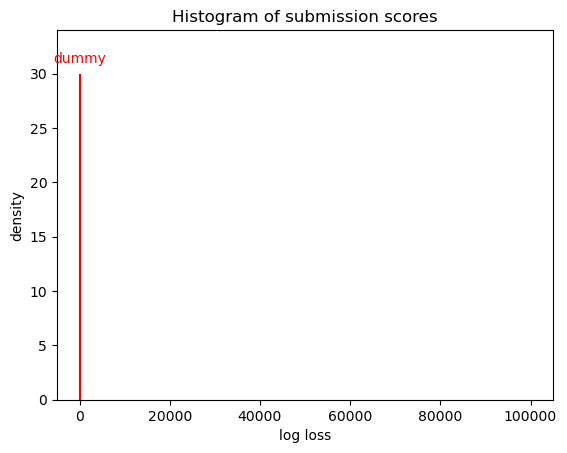

In [51]:
plt.hist(log_loss_list, bins=20, density=True, color='c')
plt.vlines([log_loss(y, np.full(len(y), 0.5))], 0, 30, color='r')
plt.text(0.693, 31, 'dummy', color='r', ha='center')
plt.title('Histogram of submission scores')
plt.xlabel('log loss')
plt.ylabel('density')
plt.ylim(0, 34)
plt.show()